<a href="https://colab.research.google.com/github/VivekAChawla/AutomatedExperiment_Summer2023/blob/main/CAMM_Hackathon_Vivek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">CAMM Hackathon - Session 1</h1>
<p align="left"><em>26 September 2025</em></p>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/KBForgeX/camm_hackathon/blob/k4my4r/docs/regressors/CAMM_Hackathon_1.ipynb)




**Data provenance** : The dataset aggregates measurements from a Dy–Er–Gd–Ho oxide wafer study in the CAMM by the Rack and Page groups


<h3>Goal: Feature → Target Prediction</h3>


This notebook hands you a **clean, standardized dataset** and a minimal prep pipeline so you can build your own predictive models. Your goal is to use the provided **features** (materials/structure descriptors) to **predict a target property** (default: *Thermal Conductivity*). The notebook **stops at data preparation**—you will implement and compare models (e.g., linear models, trees, neural nets) using the prepared data.

**What you’ll find here**
- A tidy table with `x`, `y` wafer coordinates and a set of engineered features (numeric, aligned to the same grid, with units harmonized).
- A simple example showing how to **select a target and features**, coerce to numeric, handle missing values (median imputation), and standardize inputs—ready for modeling.
- You can swap the target and feature lists to explore different prediction tasks.

**What you will do**
- Choose a **target** (e.g., `Thermal Conductivity`) and a subset of **features** you think are predictive.
- Train any models you like (sklearn, PyTorch, etc.) on the **prepared arrays**.
- Report basic metrics (RMSE, MAE, $R^2$) and, if useful, visualize predictions on the wafer grid using `x`, `y`.


#Data Preparation

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1BSZ3YyTw6dqELnL9qpfV8V5wVrbA-BPz/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1BSZ3YyTw6dqELnL9qpfV8V5wVrbA-BPz
To: /content/ReZrO_data.csv
100% 513k/513k [00:00<00:00, 11.8MB/s]


In [ ]:
path = "/content/ReZrO_data.csv"   # update if path differs
df = pd.read_csv(path)

Let's see what all properties we have in the dataset

In [ ]:
print("Dataframe shape:", df.shape)
display(df.head())


Dataframe shape: (2601, 17)


,x,y,Thermal Conductivity,Lattice Parameter(WPF),delta_d(SPF-WPF),d-spacing(WPF),Fluorite Size Disorder,Entropy,strain(LMFIT-dspacing),a111(LMFIT),a200(LMFIT),mismatch(LMFIT-lattice parameter),d111(LMFIT),d200(LMFIT),corr_length,fwhm111(LMFIT),delta_d/d
0,-2.5,-2.5,0.668247,5.245110,0.020399,2.622555,0.103832,3.924187,0.127131,5.245331,5.286782,-0.007902,3.028393,2.643391,2.94866,0.097076,0.007778
1,-2.5,-2.4,0.651635,5.245110,0.020399,2.622555,0.103727,3.927794,0.127131,5.245331,5.286782,-0.007902,3.028393,2.643391,2.94866,0.097076,0.007778
2,-2.5,-2.3,0.661063,5.244901,0.019877,2.622450,0.103588,3.939862,0.127240,5.245438,5.286226,-0.007776,3.028455,2.643113,2.94866,0.096367,0.007580
3,-2.5,-2.2,0.594712,5.244901,0.019877,2.622450,0.103447,3.951859,0.127240,5.245438,5.286226,-0.007776,3.028455,2.643113,2.94866,0.096367,0.007580
4,-2.5,-2.1,0.620809,5.244680,0.019664,2.622340,0.103338,3.955091,0.127249,5.245217,5.285954,-0.007766,3.028328,2.642977,2.94866,0.095942,0.007499


Let's plot them and see how they look

### Feature Definitions

1. **Lattice Parameter (WPF)**  
   Calculated by fitting the **whole XRD spectrum** using **TOPAS**.

2. **d-spacing (WPF)**  
   Average d-spacing calculated from fitting all peaks.

3. **Δd (SPF–WPF)**  
   Difference between *d-spacing (200 peak)* (2nd XRD peak) and *d-spacing (WPF)*:  
   $$ \Delta d = d_{WPF} - d_{\text{SPF}} $$

4. **delta_d/d**  
   Strain calculated from (2) and (3):  
   $$ \frac{\Delta d}{d} = \frac{d_{WPF} - d_{\text{SPF}}}{d_{\text{WPF}}} $$

5. **a111 (LMFit)**  
   Lattice parameter from fitting the **111 peak** (1st XRD peak) using the **LMFit** package.

6. **a200 (LMFit)**  
   Lattice parameter from fitting the **200 peak** (2nd XRD peak) using **LMFit**.

7. **Mismatch (LMFit – lattice parameter)**  
   $$ \text{Mismatch} = \frac{a_{111} - a_{200}}{a_{111}} $$

8. **d111 (LMFit)**  
   d-spacing of the 111 peak from LMFit.

9. **d200 (LMFit)**  
   d-spacing of the 200 peak from LMFit.

10. **Correlation Length**  
    Calculated from AFM images.

11. **FWHM111 (LMFit)**  
    Full Width at Half Maximum of the **111 peak**.

12. **Strain (LMFit – d-spacing)**  
    Strain calculated using LMFit d-spacing values:  
    $$ \frac{\Delta d}{d}{LMFIT} = \frac{d_{111} - d_{200}}{d_{111}} $$


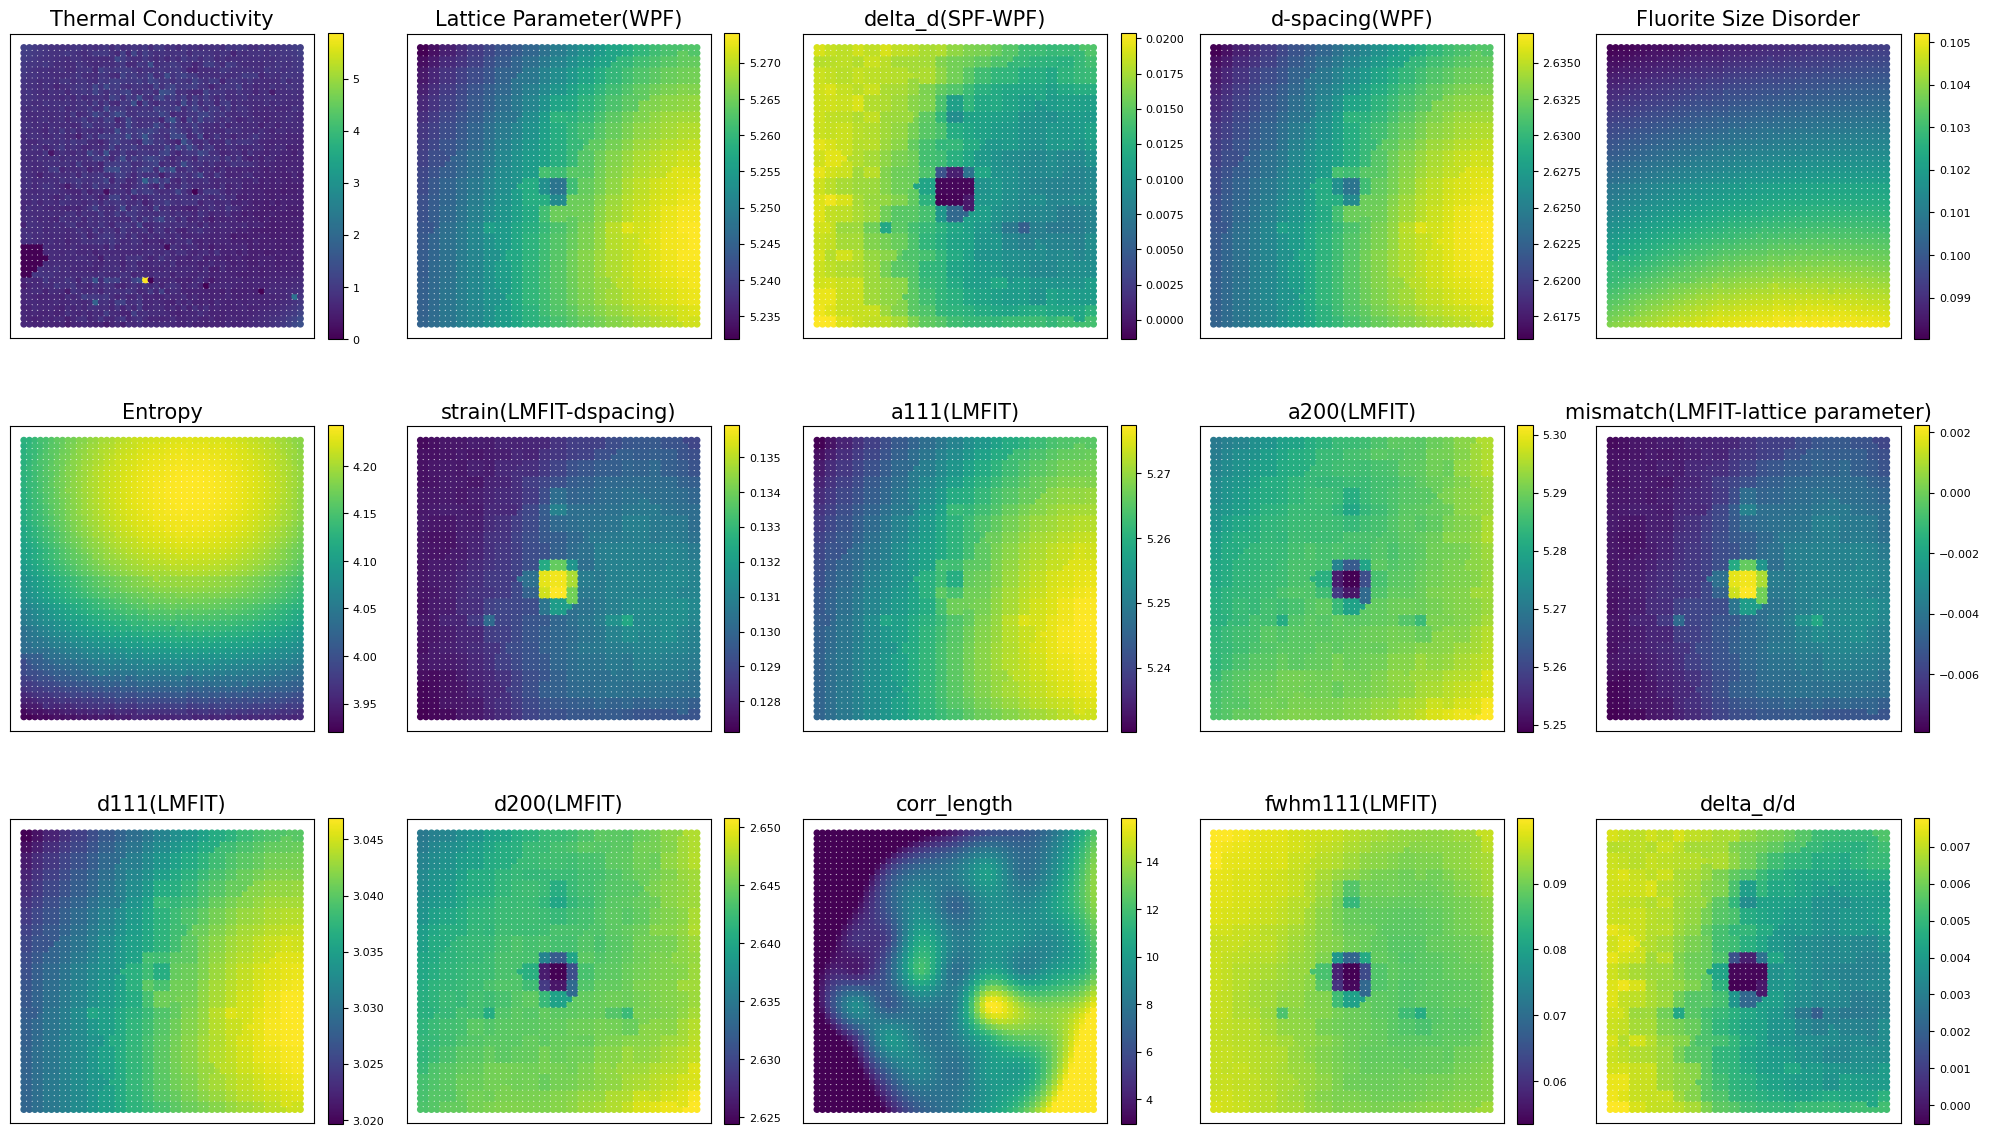

In [ ]:
x = df["x"].to_numpy()
y = df["y"].to_numpy()

feature_cols = [c for c in df.columns if c not in ["x", "y"]]

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for ax, col in zip(axes, feature_cols):
    z = pd.to_numeric(df[col], errors="coerce").to_numpy()
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)

    sc = ax.scatter(x[mask], y[mask], c=z[mask], s=16, cmap="viridis")
    ax.set_title(col, fontsize=15)
    ax.set_aspect("equal", "box")
    ax.set_xticks([]); ax.set_yticks([])

    # colorbar for each subplot
    cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

# Hide any unused subplots
for ax in axes[len(feature_cols):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

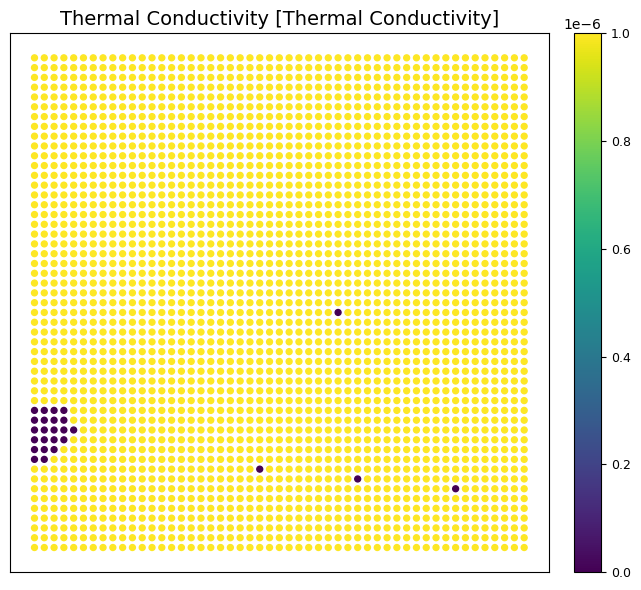

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- set the column explicitly ---
z_col = "Thermal Conductivity"   # exact match from your df.columns

# --- data ---
x = pd.to_numeric(df["x"], errors="coerce").to_numpy()
y = pd.to_numeric(df["y"], errors="coerce").to_numpy()
z = pd.to_numeric(df[z_col], errors="coerce").to_numpy()
mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)

# --- plot ---
plt.figure(figsize=(7, 6))# use them in your scatter
sc = plt.scatter(x[mask], y[mask], c=z[mask], s=18, cmap="viridis", vmin=0, vmax=0.000001)
plt.title(f"Thermal Conductivity [{z_col}]", fontsize=14)
plt.gca().set_aspect("equal", "box")
plt.xticks([]); plt.yticks([])
# plt.gca().invert_yaxis()  # uncomment if your y should increase downward
cbar = plt.colorbar(sc, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=9)
plt.tight_layout()
plt.show()


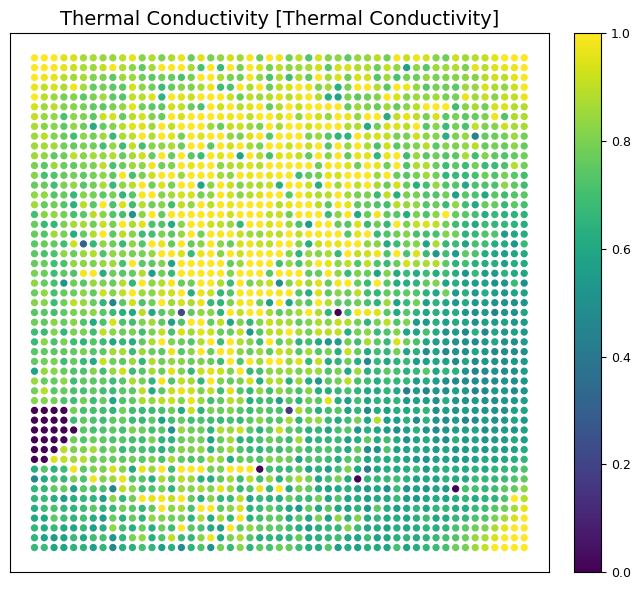

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- set the column explicitly ---
z_col = "Thermal Conductivity"   # exact match from your df.columns

# --- data ---
x = pd.to_numeric(df["x"], errors="coerce").to_numpy()
y = pd.to_numeric(df["y"], errors="coerce").to_numpy()
z = pd.to_numeric(df[z_col], errors="coerce").to_numpy()
mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)

# --- plot ---
plt.figure(figsize=(7, 6))# use them in your scatter
sc = plt.scatter(x[mask], y[mask], c=z[mask], s=18, cmap="viridis", vmin=0, vmax=1
)
plt.title(f"Thermal Conductivity [{z_col}]", fontsize=14)
plt.gca().set_aspect("equal", "box")
plt.xticks([]); plt.yticks([])
# plt.gca().invert_yaxis()  # uncomment if your y should increase downward
cbar = plt.colorbar(sc, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=9)
plt.tight_layout()
plt.show()


In [ ]:
df.columns

Index(['x', 'y', 'Thermal Conductivity', 'Lattice Parameter(WPF)',
       'delta_d(SPF-WPF)', 'd-spacing(WPF)', 'Fluorite Size Disorder',
       'Entropy', 'strain(LMFIT-dspacing)', 'a111(LMFIT)', 'a200(LMFIT)',
       'mismatch(LMFIT-lattice parameter)', 'd111(LMFIT)', 'd200(LMFIT)',
       'corr_length', 'fwhm111(LMFIT)', 'delta_d/d'],
      dtype='object')

# How to use this to train in networks?

In [ ]:
features = [
    'a111(LMFIT)', 'mismatch(LMFIT-lattice parameter)',
    'Fluorite Size Disorder', 'Entropy',
    'corr_length',
]
target = 'Thermal Conductivity'

missing = [c for c in features + [target] if c not in df.columns]
if missing:
    raise KeyError(f"These columns are missing in df: {missing}")

In [ ]:
for c in features + [target]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# 3) drop rows with missing target
df_clean = df.dropna(subset=[target]).copy()

# 4) build matrices
X_raw = df_clean[features].to_numpy(dtype=np.float32) # Input features
y_raw = df_clean[target].to_numpy(dtype=np.float32)[:, None] #Target feature that needs to be predicted
XY    = df_clean[["x","y"]].to_numpy(dtype=np.float32) if set(["x","y"]).issubset(df_clean.columns) else None # can be used to plot predictions back on the grid


In [ ]:
X_train_raw, X_val_raw, y_train, y_val, XY_train, XY_val = train_test_split(
    X_raw, y_raw, XY, test_size=0.2, random_state=42
)
# Use this to split into training and testing dataset

We split the dataset into training and test sets because we want to test our model on unseen data

## Build your network now

Make use of Chatgpt and build your own network to predict one of the features you select

# Understanding the importance of Features



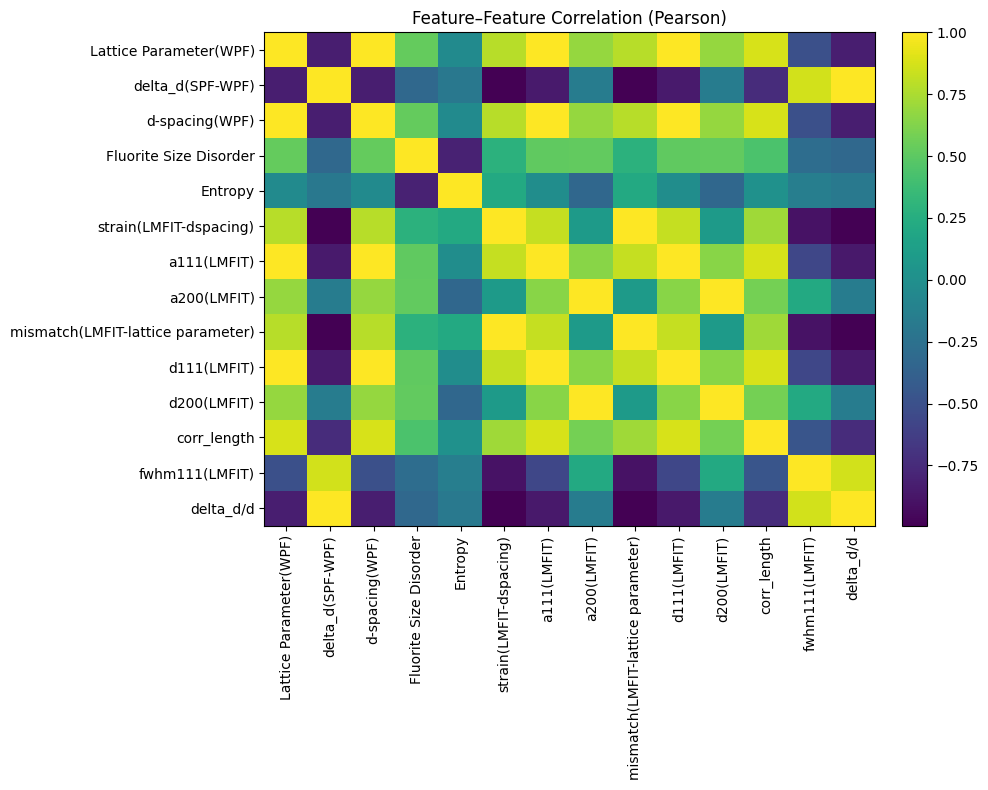

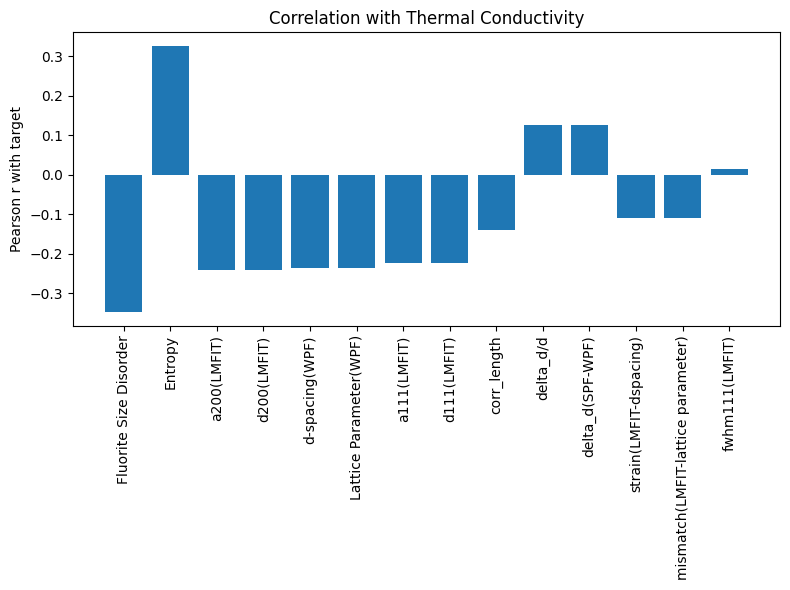


Top correlations with target:
                                    pearson_r  spearman_r
Fluorite Size Disorder             -0.347620   -0.502929
Entropy                             0.327016    0.460322
a200(LMFIT)                        -0.242043   -0.444773
d200(LMFIT)                        -0.242039   -0.444770
d-spacing(WPF)                     -0.234533   -0.407727
Lattice Parameter(WPF)             -0.234533   -0.407727
a111(LMFIT)                        -0.221833   -0.399710
d111(LMFIT)                        -0.221832   -0.399710
corr_length                        -0.138760   -0.281455
delta_d/d                           0.125915    0.294851
delta_d(SPF-WPF)                    0.125525    0.294090
strain(LMFIT-dspacing)             -0.108560   -0.281971
mismatch(LMFIT-lattice parameter)  -0.108555   -0.282026
fwhm111(LMFIT)                      0.014536    0.238773
Test R^2: 0.284

Top features by mean |SHAP|:
 Entropy                              0.048697
Fluorite Size Disord

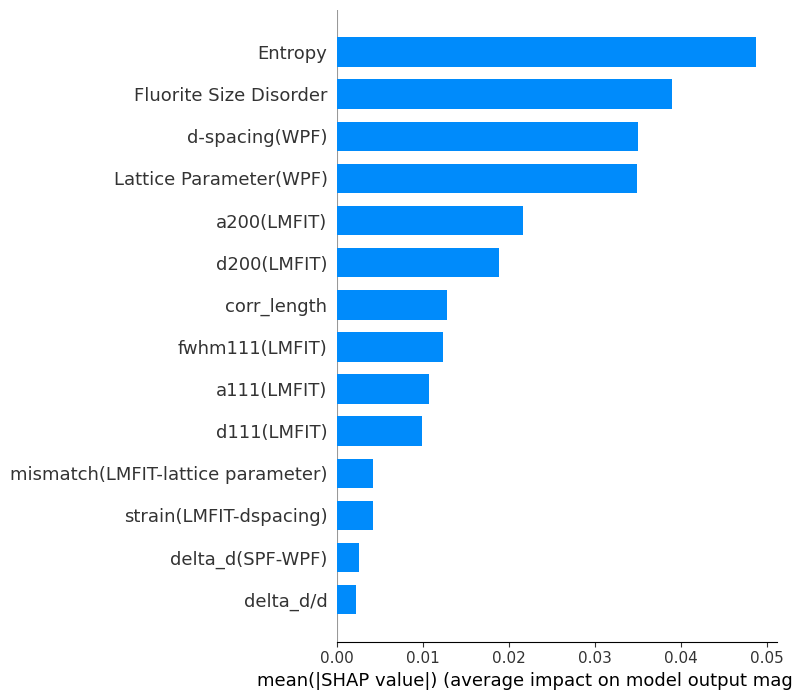

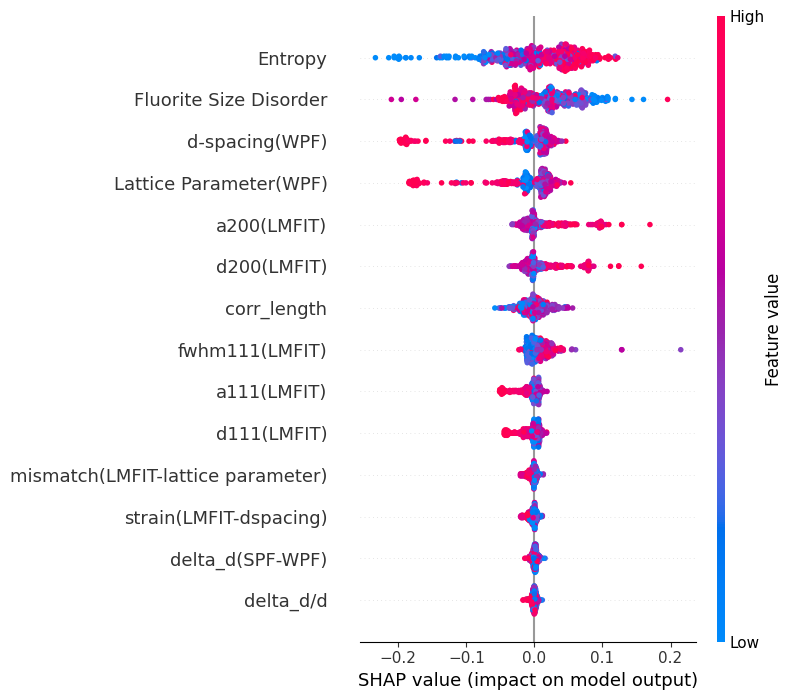

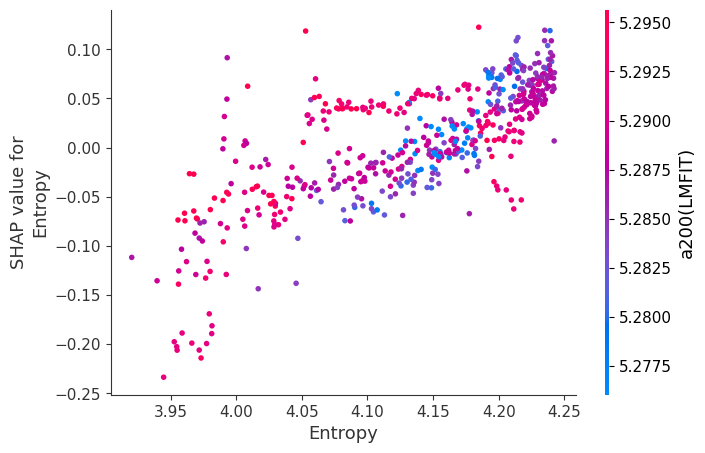

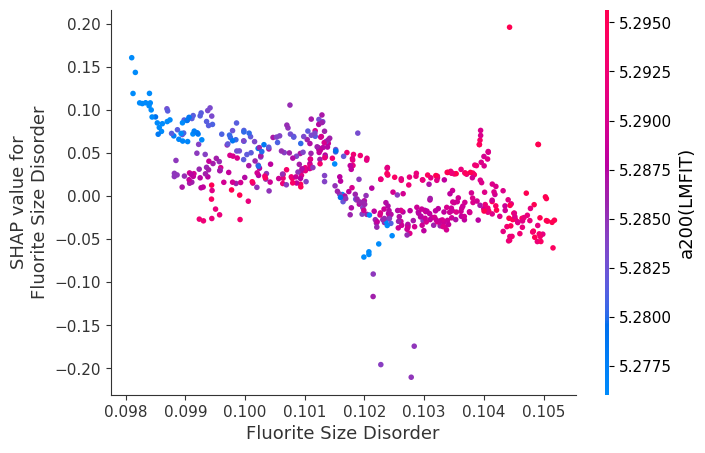

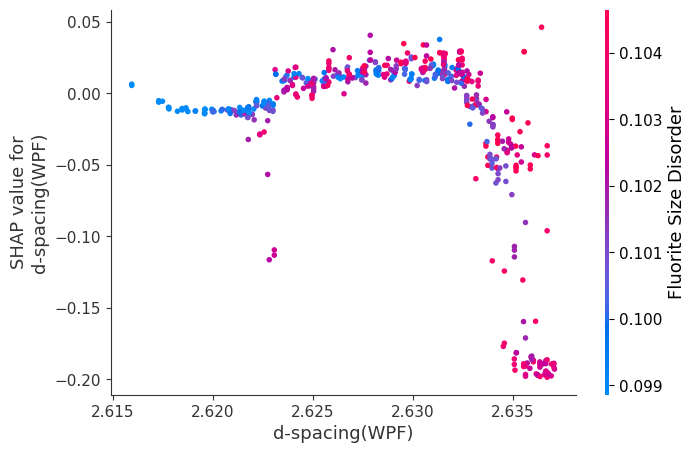

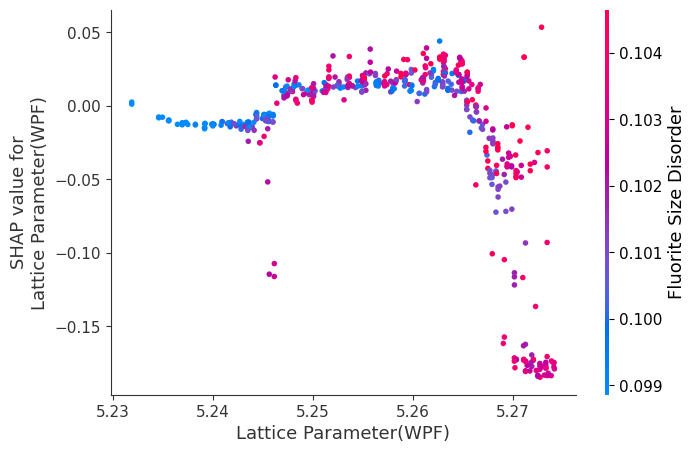

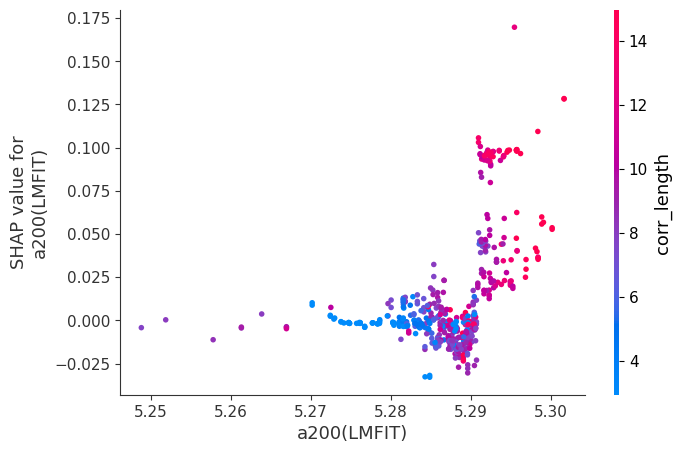

In [ ]:
# =========================
# Correlation + SHAP script
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import shap

# -------- config --------
TARGET = "Thermal Conductivity"     # change if your target has a different name
EXCLUDE_COLS = ["x", "y"]           # non-feature columns to exclude
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_ESTIMATORS = 500
MAX_DEPTH = None    # None lets RF grow fully; set (e.g., 8) for speed/regularization

# -------- data prep --------
# numeric-only copy
df_num = df.copy()
for c in df_num.columns:
    df_num[c] = pd.to_numeric(df_num[c], errors="coerce")

# features/target split
assert TARGET in df_num.columns, f"Target '{TARGET}' not found in columns!"
feature_cols = [c for c in df_num.columns if c not in EXCLUDE_COLS + [TARGET]]

X = df_num[feature_cols]
y = df_num[TARGET]

# drop rows with missing target
mask_y = np.isfinite(y.to_numpy())
X = X.loc[mask_y]
y = y.loc[mask_y]

# -------- correlation matrices --------
# Pearson (linear) and Spearman (rank)
pearson_corr = X.assign(**{TARGET: y}).corr(method="pearson")
spearman_corr = X.assign(**{TARGET: y}).corr(method="spearman")

# Plot: feature-feature Pearson heatmap
plt.figure(figsize=(10, 8))
im = plt.imshow(pearson_corr.loc[feature_cols, feature_cols], aspect="auto")
plt.title("Feature–Feature Correlation (Pearson)")
plt.xticks(range(len(feature_cols)), feature_cols, rotation=90)
plt.yticks(range(len(feature_cols)), feature_cols)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# Plot: correlation with target (bars)
corr_with_target_p = pearson_corr[TARGET].loc[feature_cols].sort_values(key=np.abs, ascending=False)
corr_with_target_s = spearman_corr[TARGET].loc[feature_cols].loc[corr_with_target_p.index]

plt.figure(figsize=(8, 6))
plt.bar(range(len(corr_with_target_p)), corr_with_target_p.values)
plt.xticks(range(len(corr_with_target_p)), corr_with_target_p.index, rotation=90)
plt.ylabel("Pearson r with target")
plt.title(f"Correlation with {TARGET}")
plt.tight_layout()
plt.show()

# (Optional) print a quick table of target correlations
corr_table = pd.DataFrame({
    "pearson_r": corr_with_target_p.values,
    "spearman_r": corr_with_target_s.values
}, index=corr_with_target_p.index)
print("\nTop correlations with target:\n", corr_table.head(15))

# -------- SHAP: tree model (RandomForest) --------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestRegressor(
        n_estimators=N_ESTIMATORS,
        max_depth=MAX_DEPTH,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Test R^2: {r2_score(y_test, y_pred):.3f}")

# Access fitted feature matrix after imputation
X_train_imp = model.named_steps["imputer"].transform(X_train)
X_test_imp  = model.named_steps["imputer"].transform(X_test)

# SHAP values
explainer = shap.TreeExplainer(model.named_steps["rf"])
shap_values = explainer.shap_values(X_test_imp)

# Mean |SHAP| importances
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
shap_importance = pd.Series(mean_abs_shap, index=feature_cols).sort_values(ascending=False)
print("\nTop features by mean |SHAP|:\n", shap_importance.head(15))

# SHAP plots (open in notebook)
shap.summary_plot(shap_values, X_test_imp, feature_names=feature_cols, plot_type="bar", show=True)
shap.summary_plot(shap_values, X_test_imp, feature_names=feature_cols, show=True)

# (Optional) dependence plot for the top few features
top_feats = shap_importance.index[:5].tolist()
for f in top_feats:
    shap.dependence_plot(f, shap_values, X_test_imp, feature_names=feature_cols, show=True)


# PYSR

Build a symbolic regression between features and targets

start with few importance features and then slowly increase

We start with 4 features:
d-spacing from whole spectra so we dont get local effects
disorder
Entropy and
corr. lengths

In [ ]:
pip install pysr

In [ ]:
# --- 1) Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from pysr import PySRRegressor


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [ ]:
# --- 2) Data prep: select features & target, filter, split ---

TARGET = "Thermal Conductivity"
TARGET_MIN = 1e-6  # drop rows with target below this

# Pick a d-spacing column from your df
D_SPACING_CANDIDATES = [
    "d-spacing(WPF)"
]
lower_map = {c.lower(): c for c in df.columns}
d_col = next((lower_map[c.lower()] for c in D_SPACING_CANDIDATES if c.lower() in lower_map), None)
if d_col is None:
    raise KeyError(f"No d-spacing column found. Looked for: {D_SPACING_CANDIDATES}")

FEATURES = [d_col,  "Fluorite Size Disorder", "Entropy"]

missing = [c for c in FEATURES + [TARGET] if c not in df.columns]
if missing:
    raise KeyError(f"Missing in df: {missing}")

# Coerce numerics
for c in FEATURES + [TARGET]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Filter: target >= 1e-6 and finite
df_f = df[(df[TARGET] >= TARGET_MIN)].dropna(subset=[TARGET]).copy()
df_f = df_f.dropna(subset=FEATURES).copy()

X = df_f[FEATURES].to_numpy(dtype=np.float64)
y = df_f[TARGET].to_numpy(dtype=np.float64)

# Guard against infs
m = np.isfinite(X).all(axis=1) & np.isfinite(y)
X, y = X[m], y[m]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

feature_names = FEATURES  # keep names for PySR
print(f"Using d-spacing column: {d_col}")
print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)


Using d-spacing column: d-spacing(WPF)
Shapes: (1931, 4) (644, 4) (1931,) (644,)


In [ ]:
X_train

array([[ 2.62345   ,  7.99500667,  0.0997821 ,  4.21807118],
       [ 2.6182225 ,  2.94866027,  0.09863852,  4.14764566],
       [ 2.620777  ,  2.94866027,  0.09939   ,  4.17881135],
       ...,
       [ 2.6281155 , 10.02330945,  0.10114032,  4.21389884],
       [ 2.626994  ,  8.2827867 ,  0.09972613,  4.2375963 ],
       [ 2.628512  ,  8.34505731,  0.10289943,  4.1080256 ]])

PySR names -> original:
 {'d_spacing_WPF_': 'd-spacing(WPF)', 'corr_length': 'corr_length', 'Fluorite_Size_Disorder': 'Fluorite Size Disorder', 'Entropy': 'Entropy'}


/usr/local/lib/python3.12/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pysr/sr.py:96: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 5.300e+03
Progress: 32 / 620 total iterations (5.161%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.528e-02  0.000e+00  y = 0.78577
3           4.480e-02  5.411e-03  y = 0.092378 ^ Fluorite_Size_Disorder
4           4.440e-02  8.782e-03  y = square(tanh(log(Entropy)))
5           4.361e-02  1.811e-02  y = square(tanh(d_spacing_WPF_ - Entropy))
7           4.245e-02  1.340e-02  y = square(0.018936 - tanh(Entropy - d_spacing_WPF_))
9           4.210e-02  4.160e-03  y = square(tanh(square(exp(-1.0418)) - (Entropy - d_spacin...
                                      g_WPF_)))
10          4.202e-02  2.017e-03  y = square(tanh((Entropy - d_spacing_WPF_) - (square(Fluor...
                                      ite_Size_Disorder) / Fluorite_Size_Disor

[ Info: Final population:
[ Info: Results saved to:


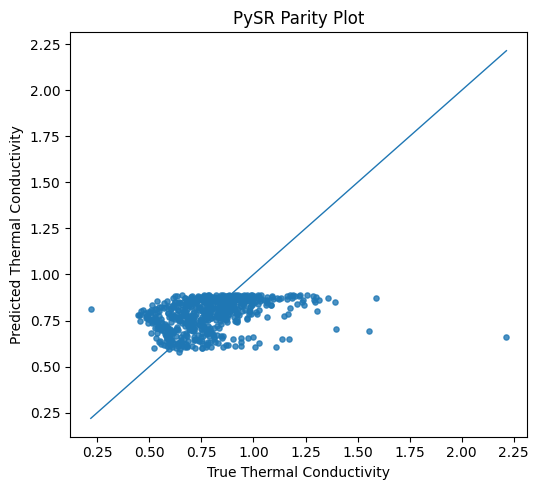

  - outputs/20250926_202230_7qA9Lf/hall_of_fame.csv


In [ ]:
import re
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from pysr import PySRRegressor
import matplotlib.pyplot as plt
import numpy as np

# --- sanitize feature names for PySR (alnum + underscore only) ---
def sanitize(name: str) -> str:
    return re.sub(r'[^0-9a-zA-Z_]', '_', name)

feature_names_safe = [sanitize(n) for n in feature_names]
name_map = dict(zip(feature_names_safe, feature_names))
print("PySR names -> original:\n", name_map)

# --- PySR model (use Julia-lambda unary ops) ---
model = PySRRegressor(
    niterations=20,                      # bump up for better search
    binary_operators=["+", "-", "*", "/", "^"],
    unary_operators=["square", "exp", "log", "tanh"],
    loss="f(x, y) = (x - y)^2", # Use a custom loss function
    complexity_of_operators = {"square": 1, "exp": 1}, # Set the complexity of the operators
    complexity_of_constants=0.5, # Set the complexity of the constants
    complexity_of_variables=1, # Set the complexity of the variables
    maxsize=12, # Allow greater complexity
    maxdepth=6) # Avoid deep nesting
)

model.fit(X_train, y_train, variable_names=feature_names_safe)

print("Best equation:", model.get_best()["equation"])

# --- evaluate ---
y_pred = model.predict(X_test)
print(f"Test R^2:  {r2_score(y_test, y_pred):.4f}")
print(f"Test MAE:  {mean_absolute_error(y_test, y_pred):.6g}")
print(f"Test MAPE: {mean_absolute_percentage_error(y_test, y_pred):.6g}")

# --- parity plot ---
plt.figure(figsize=(5.5, 5))
plt.scatter(y_test, y_pred, s=14, alpha=0.8)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, lw=1)
plt.xlabel("True Thermal Conductivity")
plt.ylabel("Predicted Thermal Conductivity")
plt.title("PySR Parity Plot")
plt.tight_layout()
plt.show()


# Comments


*   The Symbolic regression worked poorly.
*   A better thing to do would be remove the outliers first and then see its performance






